In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:


# Filter columns with 'closed_surface=True'



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3038 entries, 0 to 3037
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   filename               3038 non-null   object 
 1   dt                     3038 non-null   float64
 2   a                      3038 non-null   float64
 3   Bsize                  3038 non-null   int64  
 4   random_placement       3038 non-null   bool   
 5   random_chance          3038 non-null   float64
 6   surface_triangulation  3038 non-null   float64
 7   surface_fit            3038 non-null   float64
 8   axis_major             3038 non-null   float64
 9   axis_minor_1           3038 non-null   float64
 10  axis_minor_2           3038 non-null   float64
 11  axis_minor_mean        3038 non-null   float64
 12  aspect_ratio           3038 non-null   float64
 13  closed_surface         3038 non-null   bool   
 14  nodes_1                3038 non-null   int64  
 15  node

### Comparing the PCA and the least-squares fitting procedures

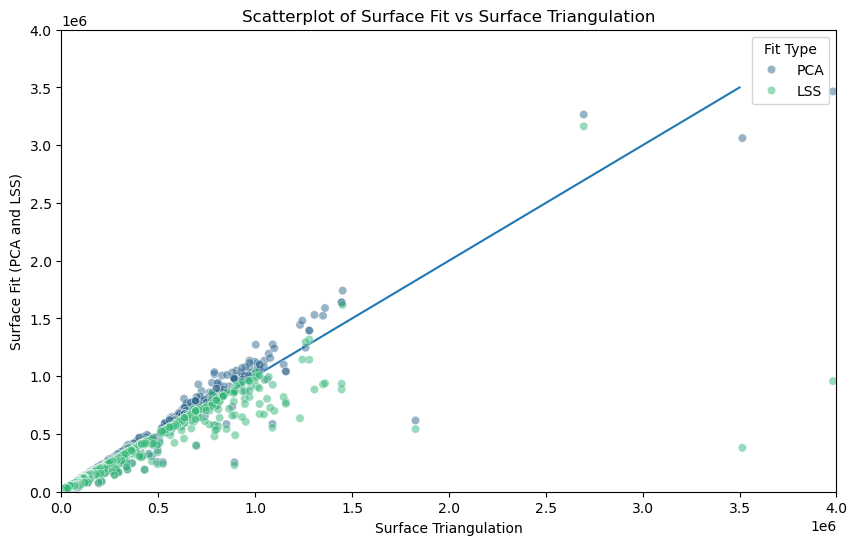

In [56]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Load the data
data_pca_fit = pd.read_csv('extracted_sim_data.csv')
data_lss_fit = pd.read_csv('extracted_sim_data_least_square_fit.csv')

# Filter the data for closed surfaces and explicitly create copies
closed_data_pca = data_pca_fit[data_pca_fit['closed_surface'] == True].copy()
closed_data_lss = data_lss_fit[data_lss_fit['closed_surface'] == True].copy()

# Prepare data for plotting
# For PCA
pca_data = closed_data_pca[['surface_triangulation', 'surface_fit']].copy()
pca_data['fit_type'] = 'PCA'

# For LSS
lss_data = closed_data_lss[['surface_triangulation', 'surface_fit']].copy()
lss_data['fit_type'] = 'LSS'

# Combine data
scatter_data = pd.concat([pca_data, lss_data])
scatter_data.rename(columns={'surface_fit': 'y_value', 'surface_triangulation': 'x_value'}, inplace=True)

# Create the scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=scatter_data,
    x='x_value',
    y='y_value',
    hue='fit_type',
    palette='viridis',
    alpha=0.5  # Set transparency
)
x= np.linspace(0,3.5*1e6,100)
sns.lineplot(x=x,y=x, zorder=0.5)

# Set plot labels and title
plt.xlabel('Surface Triangulation')
plt.ylabel('Surface Fit (PCA and LSS)')
plt.title('Scatterplot of Surface Fit vs Surface Triangulation')
plt.xlim(0,4*1e6)
plt.ylim(0,4*1e6)
# Show legend
plt.legend(title='Fit Type')

# Display the plot
plt.show()


/tmp/ipykernel_163885/2505780717.py:72: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['area_bin', 'fit_type'])['relative_error']


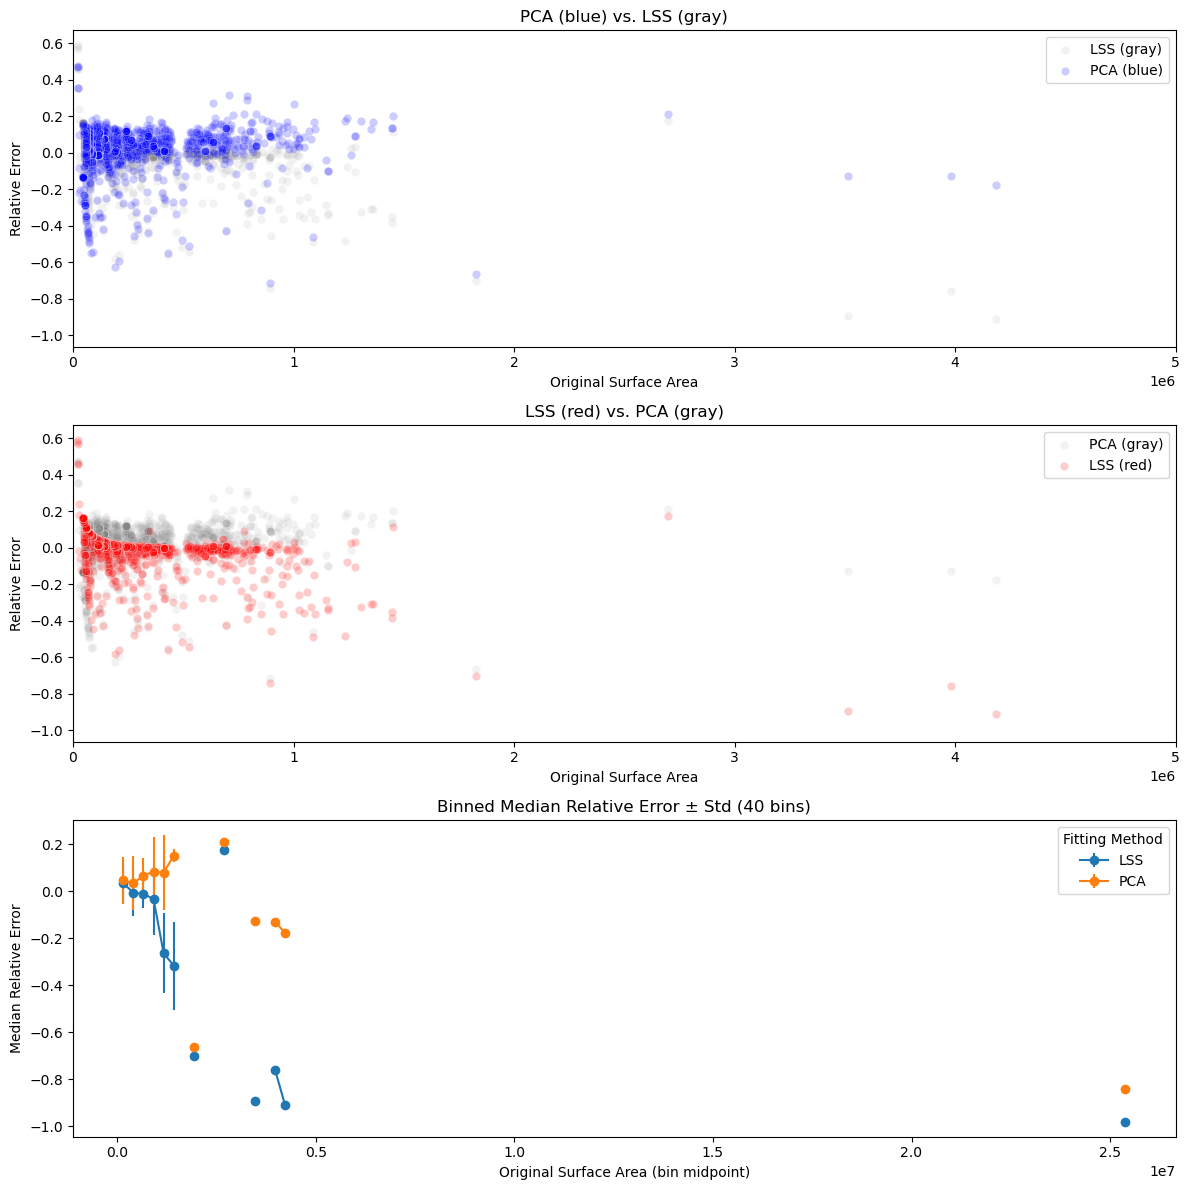

In [78]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# --- Assume `scatter_data` is already prepared ---
# scatter_data has columns:
#   - 'x_value': original surface area (from triangulation)
#   - 'relative_error': (fitted_surface - original_surface) / original_surface
#   - 'fit_type': "PCA" or "LSS"
# ------------------------------------------------

# 1) Create a figure with 3 subplots
#    - First 2 subplots (top and middle) for scatter comparisons
#    - Third subplot (bottom) for the median + std lineplot
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 12), sharey=False)

# -- SUBPLOT 1: PCA in color, LSS in gray --
sns.scatterplot(
    data=scatter_data[scatter_data['fit_type'] == 'LSS'],
    x='x_value', y='relative_error',
    color='gray', alpha=0.1, ax=ax1, label='LSS (gray)'
)
sns.scatterplot(
    data=scatter_data[scatter_data['fit_type'] == 'PCA'],
    x='x_value', y='relative_error',
    color='blue', alpha=0.2, ax=ax1, label='PCA (blue)'
)
ax1.set_title("PCA (blue) vs. LSS (gray)")
ax1.set_xlabel("Original Surface Area")
ax1.set_ylabel("Relative Error")
ax1.set(xlim=(0, 0.5e7))
ax1.legend()

# -- SUBPLOT 2: LSS in color, PCA in gray --
sns.scatterplot(
    data=scatter_data[scatter_data['fit_type'] == 'PCA'],
    x='x_value', y='relative_error',
    color='gray', alpha=0.1, ax=ax2, label='PCA (gray)'
)
sns.scatterplot(
    data=scatter_data[scatter_data['fit_type'] == 'LSS'],
    x='x_value', y='relative_error',
    color='red', alpha=0.2, ax=ax2, label='LSS (red)'
)
ax2.set_title("LSS (red) vs. PCA (gray)")
ax2.set_xlabel("Original Surface Area")
ax2.set_ylabel("Relative Error")
ax2.set(xlim=(0, 0.5e7))
ax2.legend()

plt.tight_layout()

# --- BINNED STATISTICS ---

# 1) Define 40 bins
num_bins = 100

# 2) Create the bin edges from min to max
bins = np.linspace(
    scatter_data['x_value'].min(),
    scatter_data['x_value'].max(),
    num_bins + 1
)

# 3) Cut 'x_value' into bins
scatter_data['area_bin'] = pd.cut(scatter_data['x_value'], bins=bins)

# 4) Group by area_bin and fit_type, then compute stats (mean, median, std, count)
stats_df = (
    scatter_data
    .groupby(['area_bin', 'fit_type'])['relative_error']
    .agg(['mean', 'median', 'std', 'count'])
    .reset_index()
)

# Create a column with the midpoint of each bin for plotting
stats_df['bin_mid'] = stats_df['area_bin'].apply(lambda x: x.mid)

# --- SUBPLOT 3: Median + Std lineplot (PCA vs. LSS) ---

# We will plot the median as the main value, and std as error bars
for fit_type, grp in stats_df.groupby('fit_type'):
    ax3.errorbar(
        x=grp['bin_mid'],
        y=grp['median'],
        yerr=grp['std'],           # standard deviation as error bar
        label=fit_type,
        fmt='-o'                   # line with circle markers
    )

ax3.set_title("Binned Median Relative Error ± Std (40 bins)")
ax3.set_xlabel("Original Surface Area (bin midpoint)")
ax3.set_ylabel("Median Relative Error")
ax3.legend(title="Fitting Method")

plt.tight_layout()
plt.show()


/tmp/ipykernel_163885/1022853304.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  closed_data_pca['fit_type'] = 'PCA'
/tmp/ipykernel_163885/1022853304.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  closed_data_lss['fit_type'] = 'LSS'


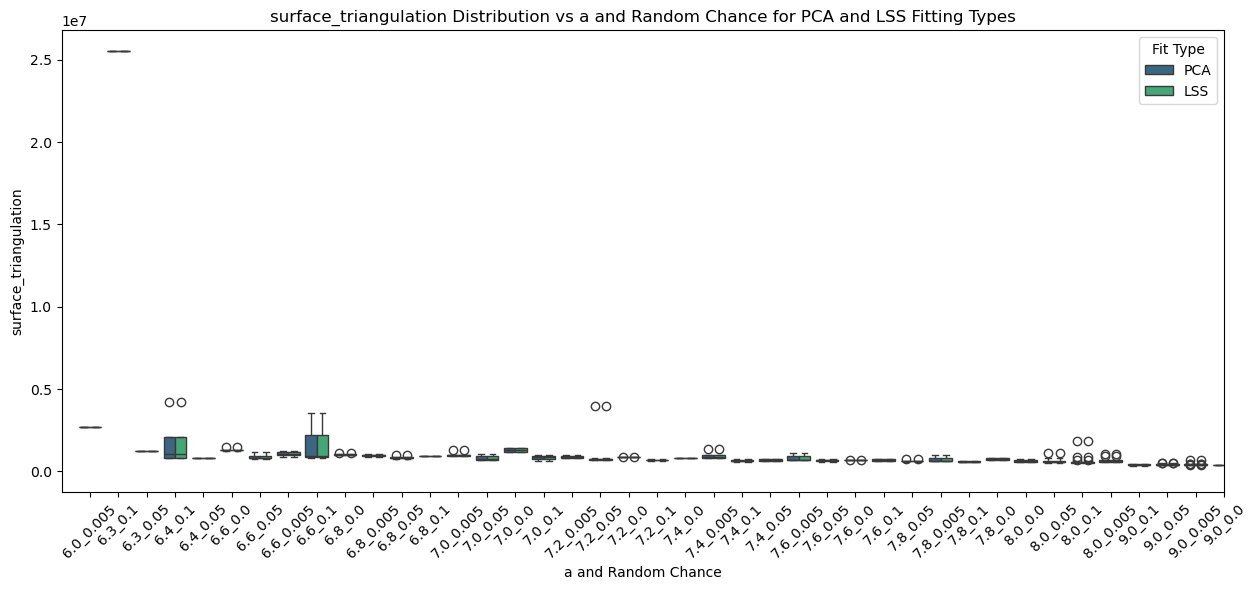

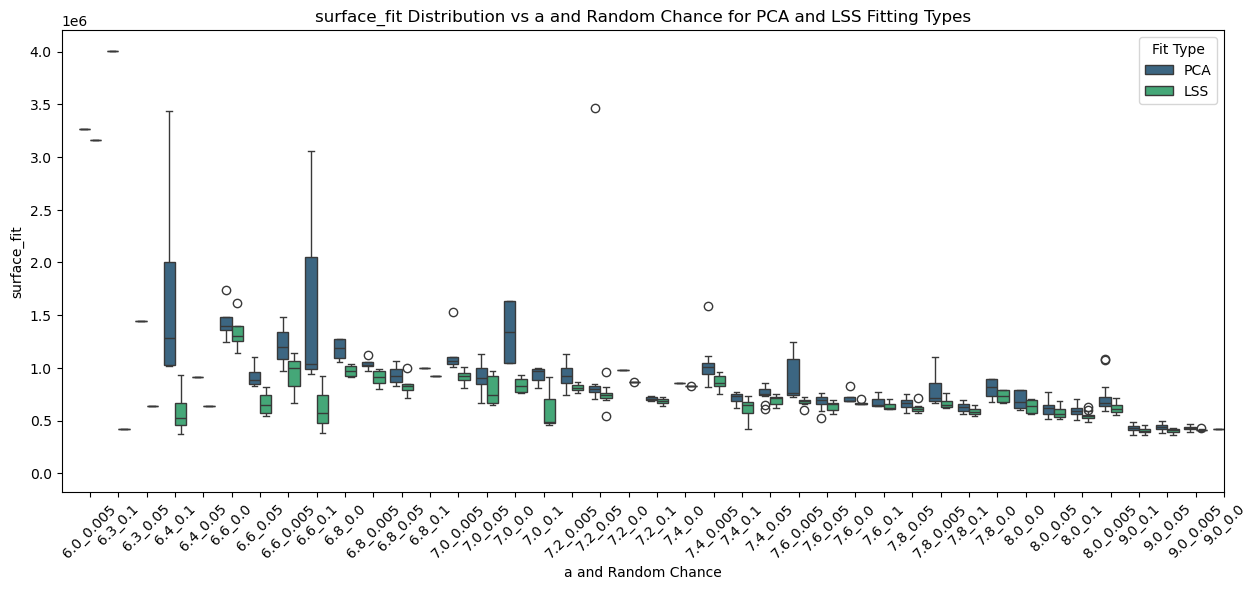

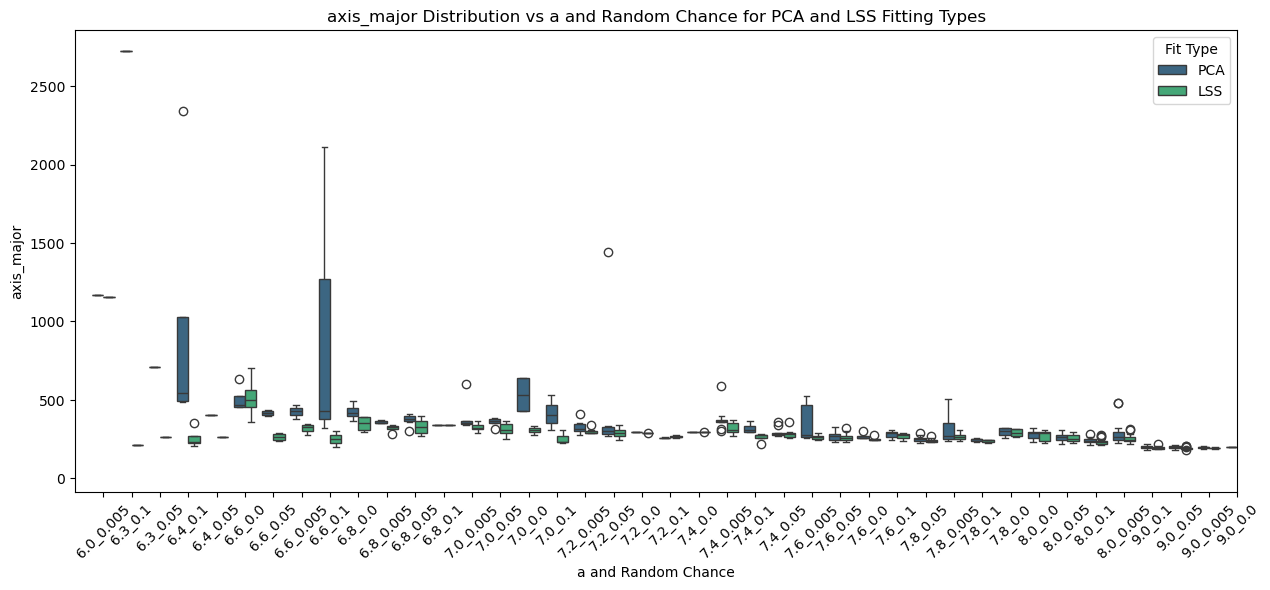

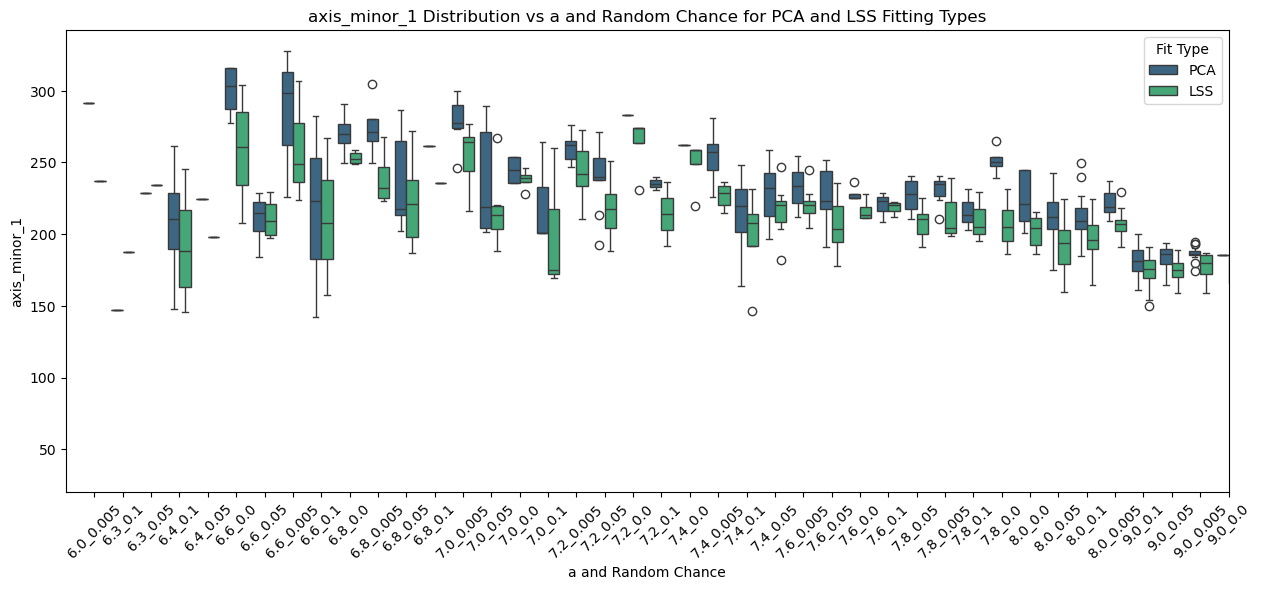

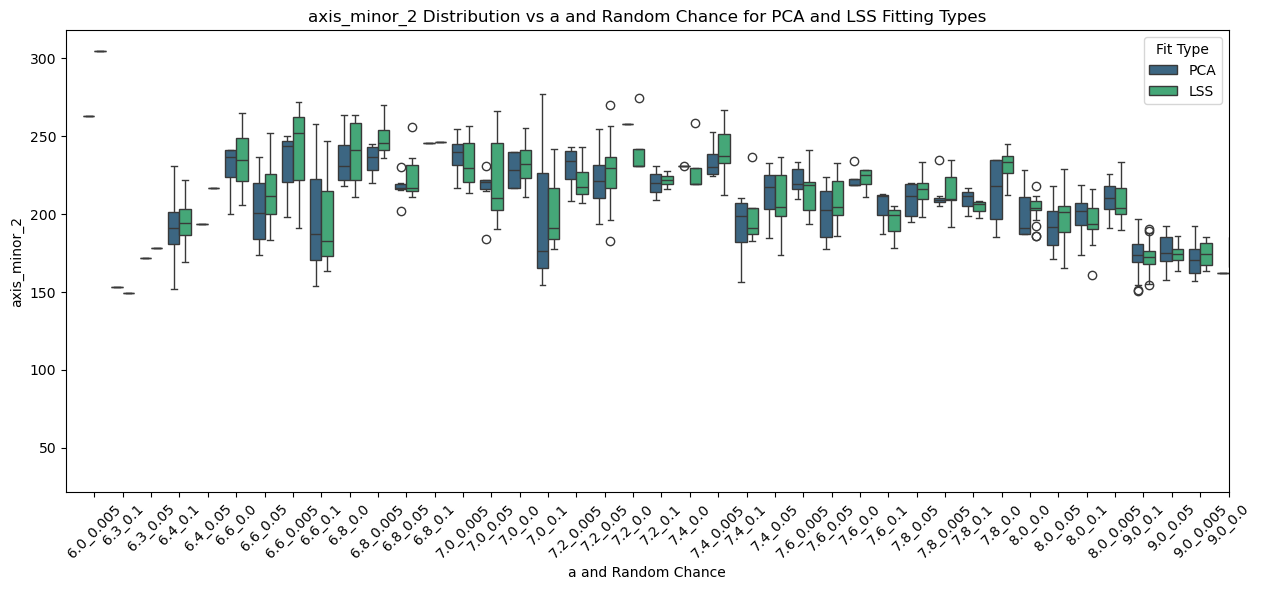

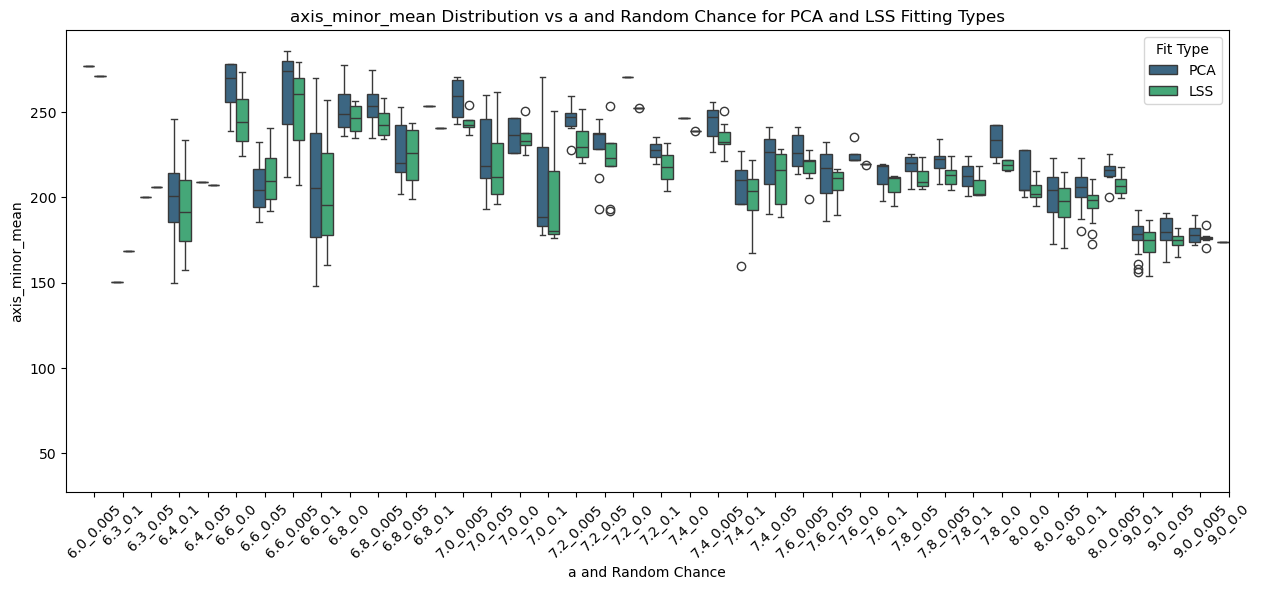

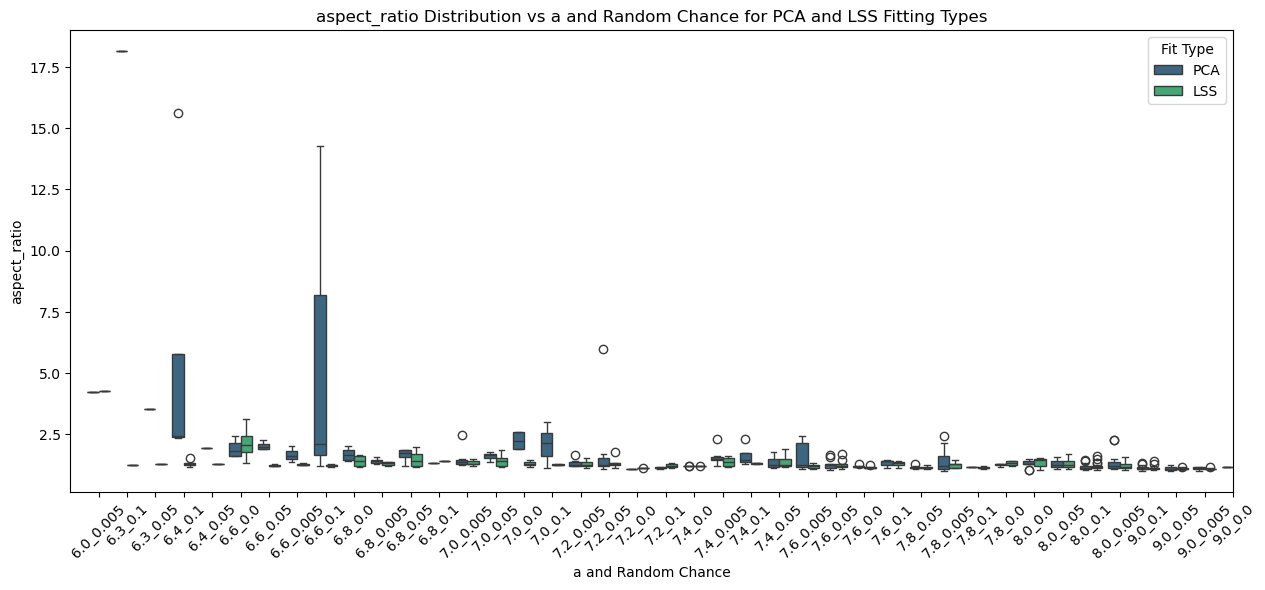

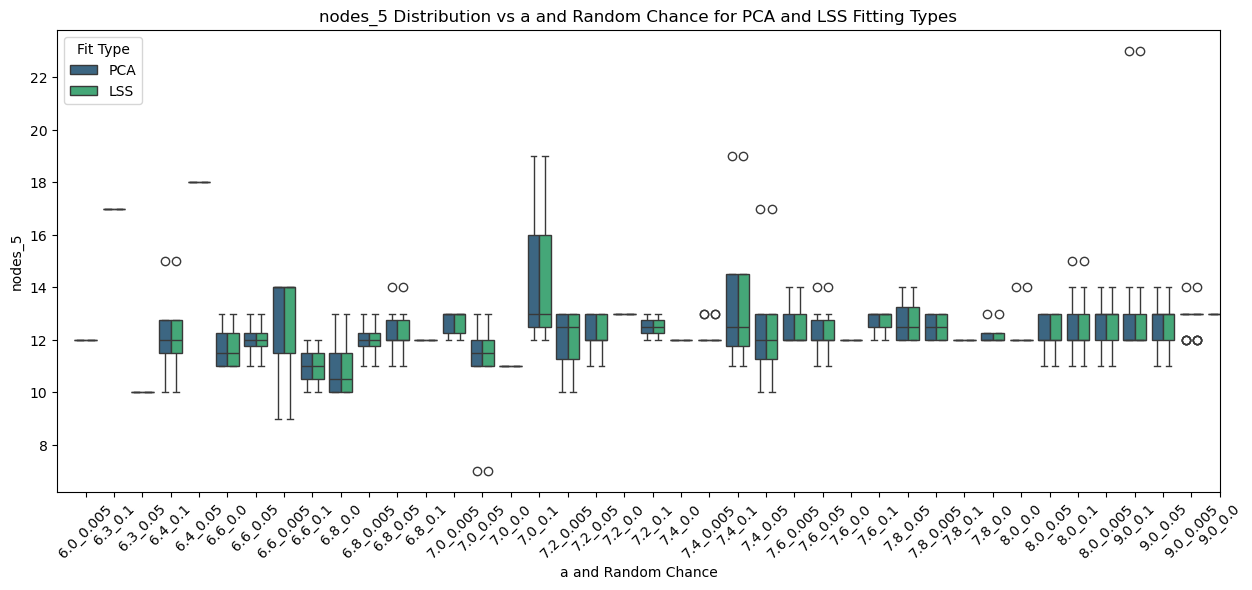

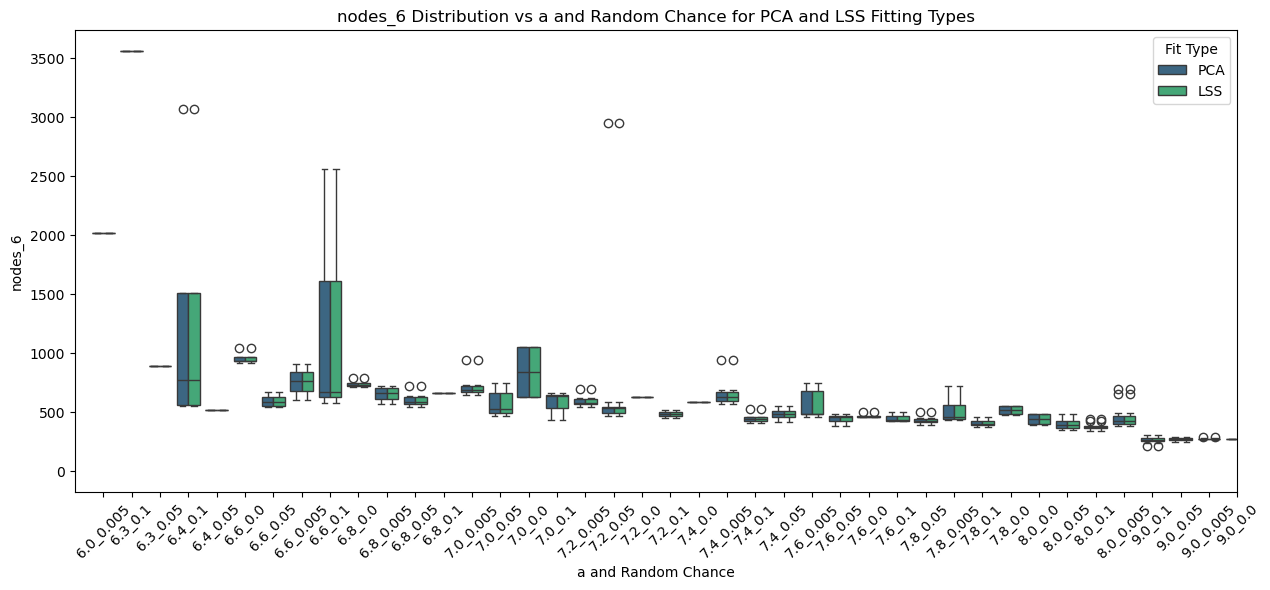

In [34]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the data
data_pca_fit = pd.read_csv('extracted_sim_data.csv')
closed_data_pca = data_pca_fit[data_pca_fit['closed_surface'] == True]

data_lss_fit = pd.read_csv('extracted_sim_data_least_square_fit.csv')
closed_data_lss = data_lss_fit[data_lss_fit['closed_surface'] == True]

# Add a new column to distinguish fitting types
closed_data_pca['fit_type'] = 'PCA'
closed_data_lss['fit_type'] = 'LSS'

# Combine the datasets
combined_data = pd.concat([closed_data_pca, closed_data_lss])

# Create a composite column for 'a' and 'random_chance'
combined_data['a_random_chance'] = combined_data['a'].astype(str) + '_' + combined_data['random_chance'].astype(str)

# Select columns for plotting
select_cols = [
    "surface_triangulation", "surface_fit", "axis_major", "axis_minor_1", 
    "axis_minor_2", "axis_minor_mean", "aspect_ratio", "nodes_5", "nodes_6"
]

# Loop through all numerical columns to create box plots
for col in select_cols:
    plt.figure(figsize=(15, 6))
    
    # Create the box plot using seaborn
    sns.boxplot(
        data=combined_data,
        x='a_random_chance',
        y=col,
        hue='fit_type',
        palette='viridis'
    )
    
    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45)
    plt.xlim(-1, 40)
    # Set plot labels and title
    plt.xlabel('a and Random Chance')
    plt.ylabel(col)
    plt.title(f'{col} Distribution vs a and Random Chance for PCA and LSS Fitting Types')
    
    # Show the legend
    plt.legend(title='Fit Type', loc='best')

    # Display the plot
    plt.show()


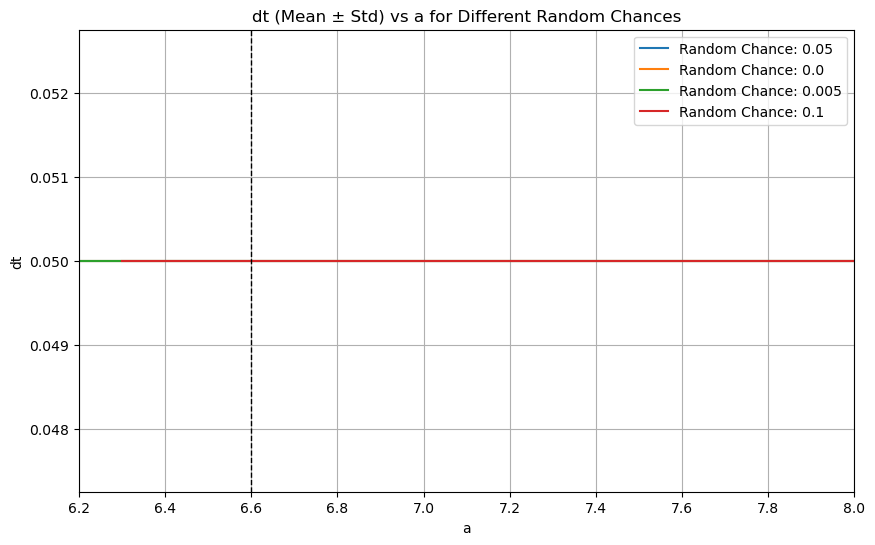

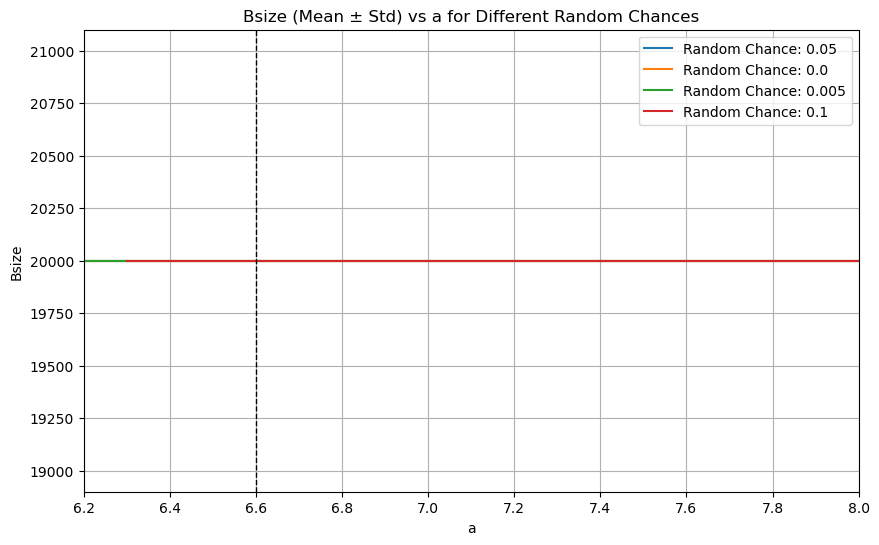

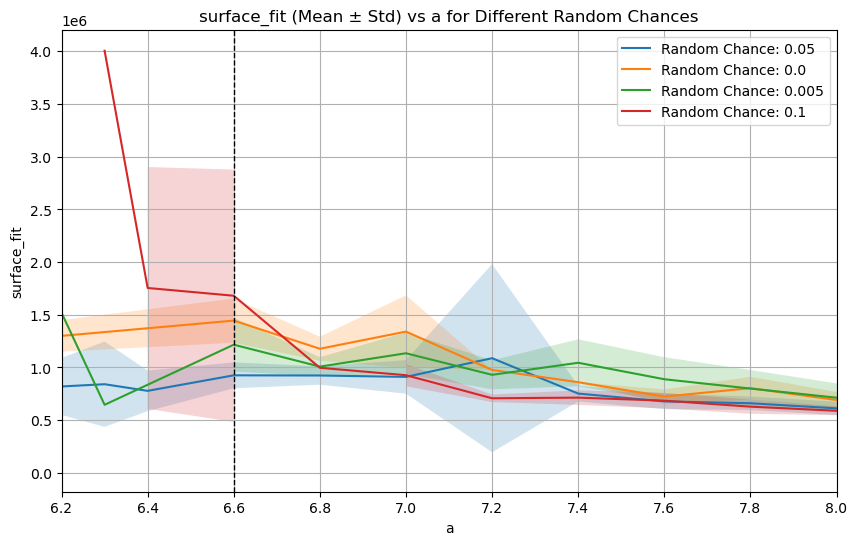

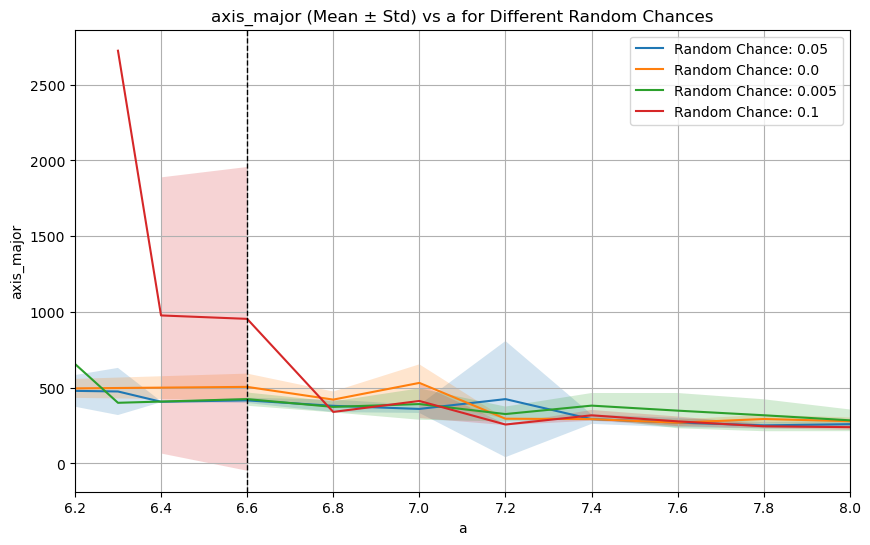

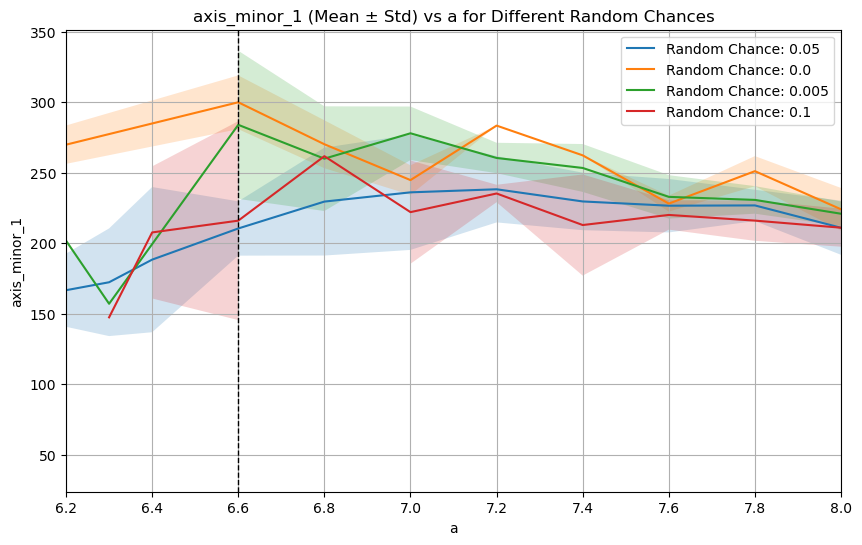

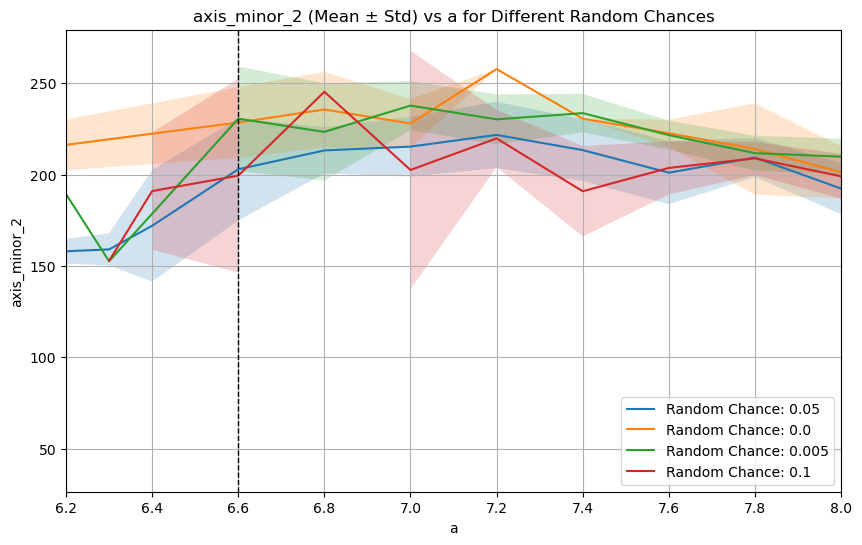

Skipping axis_minor as standard deviation column is missing.
Skipping axis_minor_std as standard deviation column is missing.


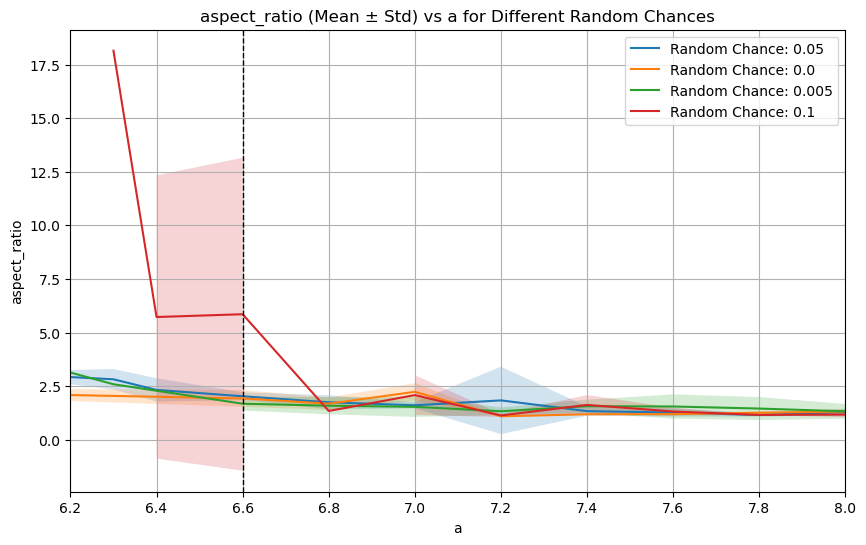

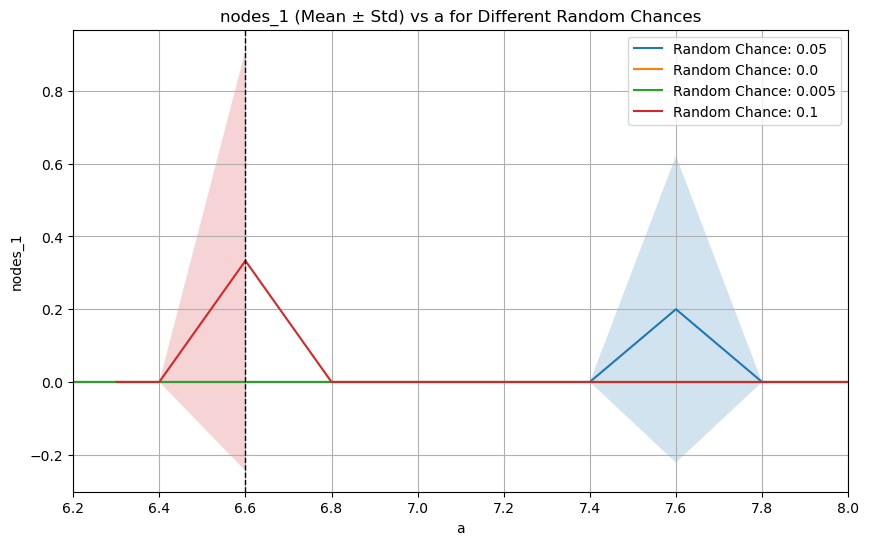

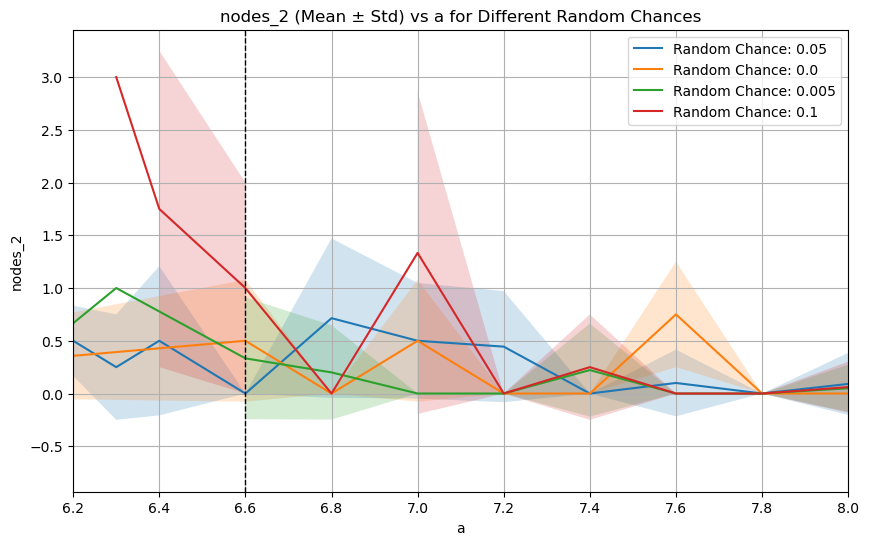

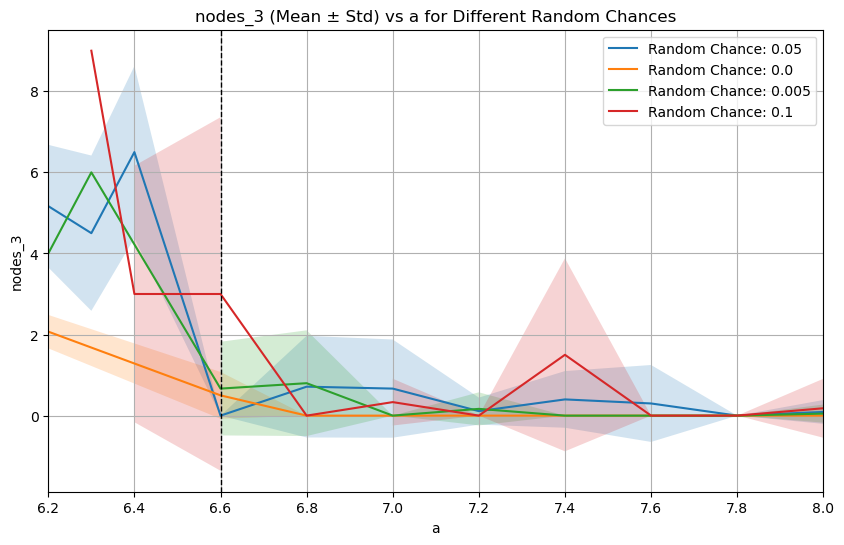

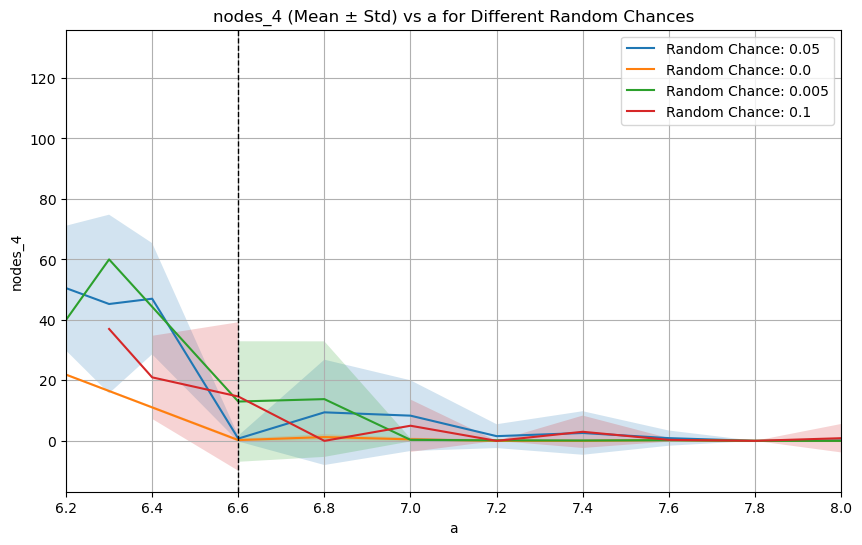

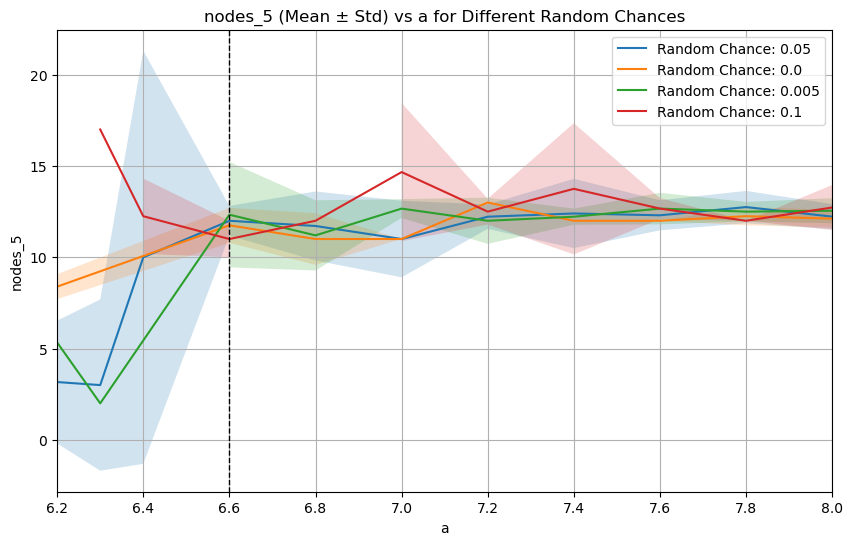

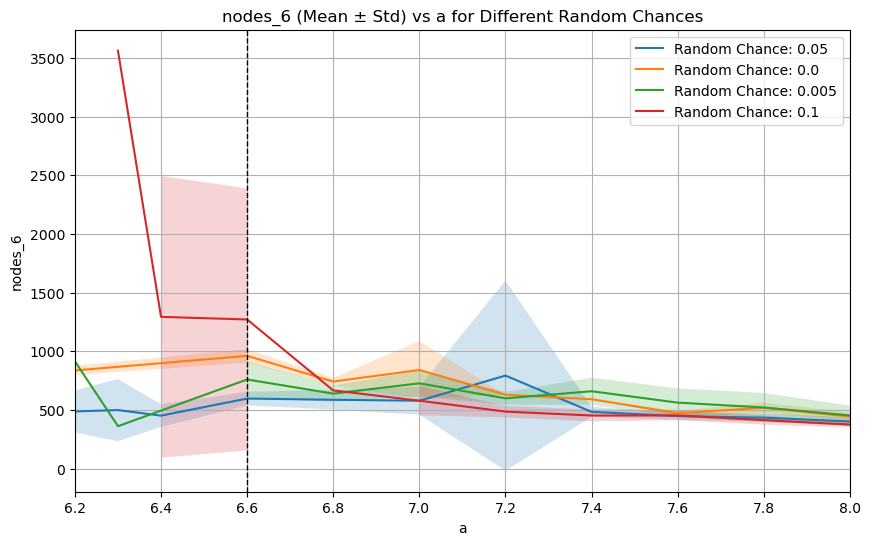

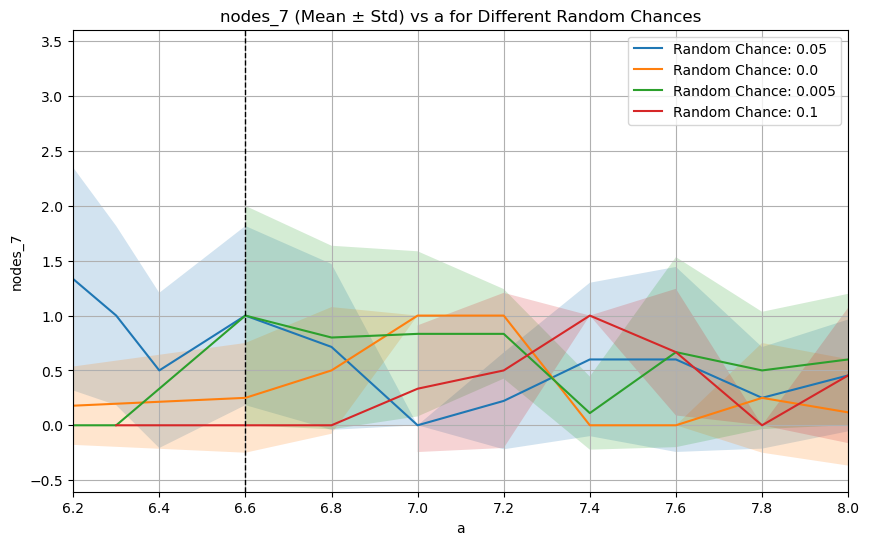

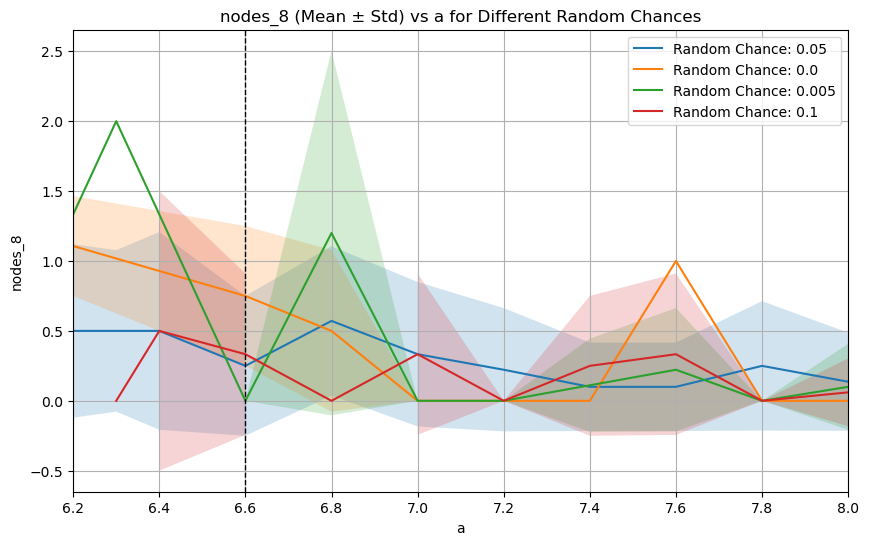

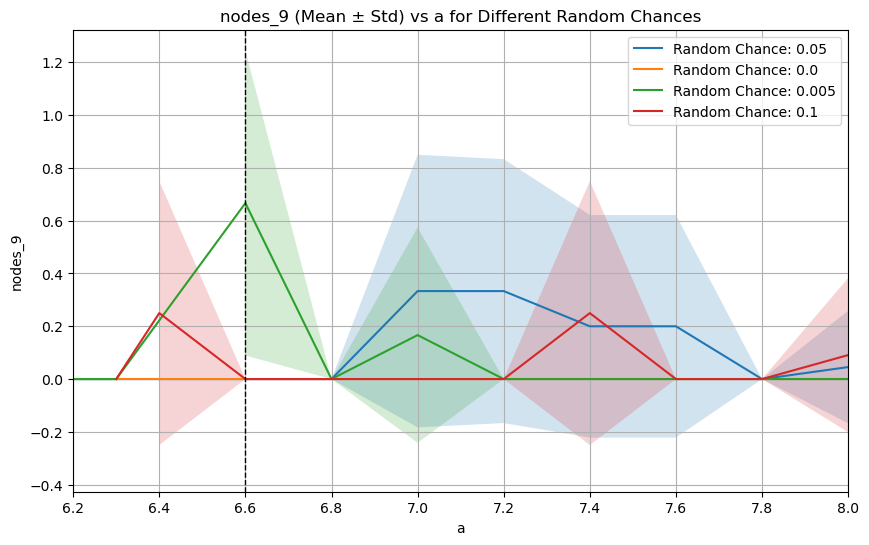

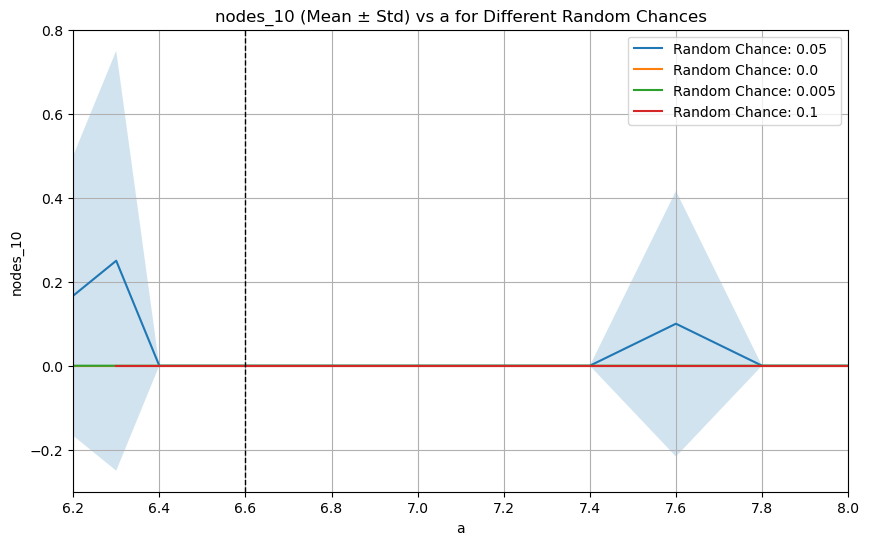

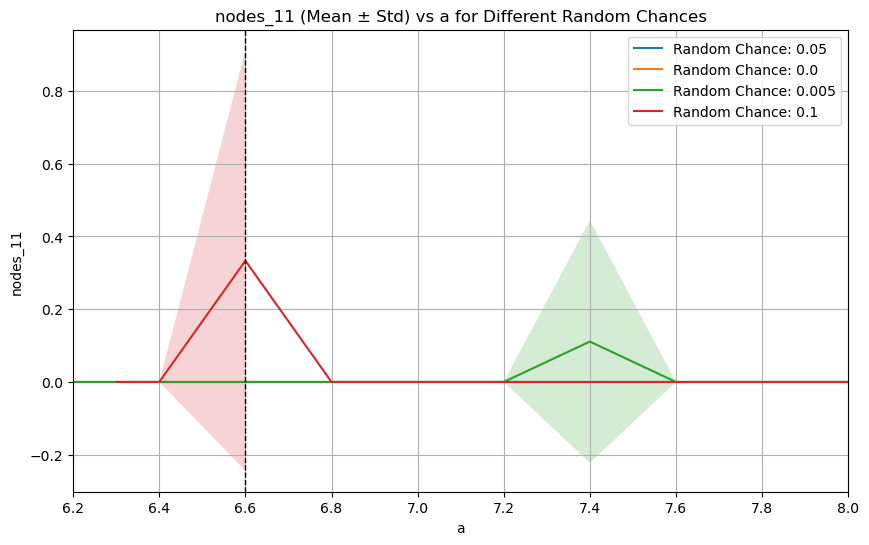

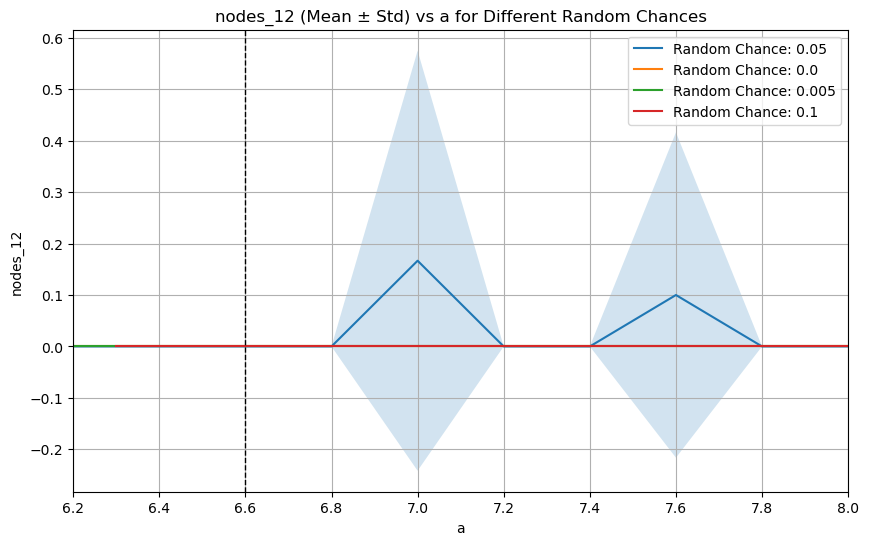

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the data
df = pd.read_csv('extracted_sim_data.csv')
closed_data = data[data['closed_surface'] == True]

# Grouping and aggregating data
grouped = closed_data.groupby(['a', 'random_chance']).agg(
    {col: ['mean', 'std'] for col in closed_data.select_dtypes(include=['number']).columns if col not in ['a', 'random_chance']}
).reset_index()

# Flattening multi-level columns for ease of access
grouped.columns = ['_'.join(col).strip('_') if col[1] else col[0] for col in grouped.columns]

# Loop through all numerical columns to create plots
numeric_cols = [col for col in grouped.columns if 'mean' in col and 'surface_triangulation' not in col]
for col in numeric_cols:
    col_name = col.replace('_mean', '')
    std_col = col.replace('mean', 'std')
    
    # Ensure the required std column exists
    if std_col not in grouped.columns:
        print(f"Skipping {col_name} as standard deviation column is missing.")
        continue
    
    # Extract unique random_chance values
    random_chance_values = grouped['random_chance'].unique()
    
    # Create the plot
    plt.figure(figsize=(10, 6))
    for rc in random_chance_values:
        subset = grouped[grouped['random_chance'] == rc]
        a_values = subset['a'].to_numpy()
        mean = subset[col].to_numpy()
        std = subset[std_col].to_numpy()
        
        # Skip plotting if any array is empty
        if len(a_values) == 0 or len(mean) == 0 or len(std) == 0:
            print(f"Skipping plot for random chance {rc} and column {col_name} due to empty data.")
            continue
        
        # Plot mean line
        plt.plot(a_values, mean, label=f'Random Chance: {rc}')

        # Fill area between mean ± std
        plt.fill_between(a_values, mean - std, mean + std, alpha=0.2)
    
    plt.axvline(x=6.6, color='black', linestyle='--', linewidth=1)
    # Set plot labels and title
    
    plt.xlabel('a')
    plt.xlim(6.2, 8)
    plt.ylabel(col_name)
    plt.title(f'{col_name} (Mean ± Std) vs a for Different Random Chances')
    plt.legend()
    plt.grid(True)
    plt.show()
